In [64]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier 
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import sum, avg, col, when, count, mean, expr, percentile_approx, skewness, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import numpy as np

In [43]:
# Building SparkSession o connect to the hive.

spark = SparkSession.builder.appName("Project_fraud_detection").config("spark.sql.warehouse.dir", "gs://dataproc-staging-us-central1-187458182383-1ibqeonc/spark-warehouse").enableHiveSupport().getOrCreate()

In [65]:
spark =SparkSession.builder.appName("fraud_detection").getOrCreate()

In [66]:
# Creating spark dataframe by reading csv file.
df = spark.read.csv("creditcard.csv", header=True, inferSchema=True)
df.show()

+---+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------+-----+
| id|                  V1|                  V2|                V3|                  V4|                  V5|                  V6|                 V7|                  V8|                  V9|                V10|                 V11|               V12|                 V13|                V14|                 V15|                 V16|                V17|                 V18|                 V19|    

In [67]:
# Fetching total number of records in dataset.
print(f"The table consists: {df.count()} records.")

The table consists: 568630 records.


In [68]:
# Creating temporary view.
df.createOrReplaceTempView("creditcarddata")

## Data Cleaning

In [69]:
# Checking for null values in each column.
spark.sql("SELECT * FROM creditcarddata WHERE id IS NULL OR V1 IS NULL OR V2 IS NULL OR V3 IS NULL OR V4 IS NULL OR V5 IS NULL OR V6 IS NULL OR V7 IS NULL OR V8 IS NULL OR V9 IS NULL OR V10 IS NULL OR V11 IS NULL OR V12 IS NULL OR V13 IS NULL OR V14 IS NULL OR V15 IS NULL OR V16 IS NULL OR V17 IS NULL OR V18 IS NULL OR V19 IS NULL OR V20 IS NULL OR V21 IS NULL OR V22 IS NULL OR V23 IS NULL OR V24 IS NULL OR V25 IS NULL OR V26 IS NULL OR V27 IS NULL OR V28 IS NULL OR Amount IS NULL OR Class IS NULL").show()

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
| id| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



In [70]:
# Calculate Q1 and Q3
percentiles = df.approxQuantile("Amount", [0.25, 0.75], 0.05)
Q1, Q3 = percentiles[0], percentiles[1]

# eliminating extreme values, just by focusing the middle spread.
IQR = Q3 - Q1 # Interquartile Range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Display the calculated values
print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}, Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

Q1: 6249.34, Q3: 17209.13, IQR: 10959.79, Lower Bound: -10190.345000000001, Upper Bound: 33648.815


In [71]:
# Filtering outliers(removing extreme values that affects our analysis)
fil_outliers = df.filter((col("amount") >= lower_bound) & (col("Amount") <= upper_bound))

# Creating temporary view
fil_outliers.createOrReplaceTempView("cleaneddata")

In [72]:
# Checking the loaded data.
spark.sql("SELECT * FROM cleaneddata LIMIT 5").show()

+---+--------------------+--------------------+------------------+--------------------+-------------------+------------------+------------------+--------------------+-------------------+------------------+--------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------+-----+
| id|                  V1|                  V2|                V3|                  V4|                 V5|                V6|                V7|                  V8|                 V9|               V10|                 V11|               V12|                V13|                V14|                V15|                 V16|                V17|                V18|                V19|                V20|      

## Descriptive statistics and Aggregation

In [73]:
# Fetching 'Minimum' and 'Maximum' amounts.
spark.sql("SELECT COUNT(*) AS Total_No_Records, MIN(Amount) AS Minimum, MAX(Amount) AS Maximum FROM cleaneddata").show()

+----------------+-------+--------+
|Total_No_Records|Minimum| Maximum|
+----------------+-------+--------+
|          568630|  50.01|24039.93|
+----------------+-------+--------+



In [74]:
# Grouping 'class' and shows the total number of records for each.
df.groupBy("Class").count().show()

+-----+------+
|Class| count|
+-----+------+
|    1|284315|
|    0|284315|
+-----+------+



In [75]:
# Fetching 'Average amount'.
df.select(mean(col("Amount")).alias('Average amount')).show()

+------------------+
|    Average amount|
+------------------+
|12041.957634577911|
+------------------+



In [76]:
# Fetching 'Total' and 'Average' amount for each 'class' group.
df.groupBy('class').agg(count('*').alias('Total_transactions'), sum('Amount').alias('Total_amount'), avg('Amount').alias('Average_amount')).show()

+-----+------------------+-------------------+------------------+
|class|Total_transactions|       Total_amount|    Average_amount|
+-----+------------------+-------------------+------------------+
|    1|            284315|3.428157045350039E9|12057.601763361197|
|    0|            284315|3.419261324399995E9|12026.313505794611|
+-----+------------------+-------------------+------------------+



In [77]:
# Calculating 'skewness' and 'kurtosis'
df.select(skewness(df["amount"]).alias('SKEWNESS'), kurtosis(df["amount"]).alias('KURTOSIS')).show()

+--------------------+------------------+
|            SKEWNESS|          KURTOSIS|
+--------------------+------------------+
|0.001655580593859...|-1.198863707275511|
+--------------------+------------------+



In [78]:
# Converting spark dataframe to pandas dataframe.
df_pandas = df.toPandas()

In [79]:
# Descriptive statistics.
df_pandas.describe()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,568630.000000,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,...,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,568630.000000,568630.0
mean,284314.500000,-5.638058e-17,-1.323544e-16,-3.518788e-17,-2.879008e-17,5.837989e-17,-3.918650e-17,-3.358843e-17,1.059635e-17,3.998623e-17,...,2.539125e-17,3.623752e-18,-1.802504e-18,-1.469494e-17,-3.228888e-17,-7.797314e-18,-3.598760e-17,2.579112e-17,12041.957635,0.5
std,164149.486122,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,6919.644449,0.5
min,0.000000,-3.495584e+00,-4.996657e+01,-3.183760e+00,-4.951222e+00,-9.952786e+00,-2.111111e+01,-4.351839e+00,-1.075634e+01,-3.751919e+00,...,-1.938252e+01,-7.734798e+00,-3.029545e+01,-4.067968e+00,-1.361263e+01,-8.226969e+00,-1.049863e+01,-3.903524e+01,50.010000,0.0
25%,142157.250000,-5.652859e-01,-4.866777e-01,-6.492987e-01,-6.560203e-01,-2.934955e-01,-4.458712e-01,-2.835329e-01,-1.922572e-01,-5.687446e-01,...,-1.664408e-01,-4.904892e-01,-2.376289e-01,-6.515801e-01,-5.541485e-01,-6.318948e-01,-3.049607e-01,-2.318783e-01,6054.892500,0.0
50%,284314.500000,-9.363846e-02,-1.358939e-01,3.528579e-04,-7.376152e-02,8.108788e-02,7.871758e-02,2.333659e-01,-1.145242e-01,9.252647e-02,...,-3.743065e-02,-2.732881e-02,-5.968903e-02,1.590123e-02,-8.193162e-03,-1.189208e-02,-1.729111e-01,-1.392973e-02,12030.150000,0.5
75%,426471.750000,8.326582e-01,3.435552e-01,6.285380e-01,7.070047e-01,4.397368e-01,4.977881e-01,5.259548e-01,4.729905e-02,5.592621e-01,...,1.479787e-01,4.638817e-01,1.557153e-01,7.007374e-01,5.500147e-01,6.728879e-01,3.340230e-01,4.095903e-01,18036.330000,1.0
max,568629.000000,2.229046e+00,4.361865e+00,1.412583e+01,3.201536e+00,4.271689e+01,2.616840e+01,2.178730e+02,5.958040e+00,2.027006e+01,...,8.087080e+00,1.263251e+01,3.170763e+01,1.296564e+01,1.462151e+01,5.623285e+00,1.132311e+02,7.725594e+01,24039.930000,1.0


In [80]:
# Fetching Top 5 highest transaction amount.
df_pandas.sort_values(by='Amount', ascending=False).head(5)

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
473871,473871,-2.003609,2.555784,-1.940124,2.230373,-2.394061,0.258814,-2.803543,-1.085524,-2.550775,...,-2.075900,2.656152,1.954903,1.119110,-1.213595,0.315536,-3.024185,-1.780374,24039.93,1
85369,85369,0.611042,-0.931258,0.952852,-0.417427,-0.240336,0.287658,0.308858,-0.138887,1.485640,...,-0.138827,-0.623633,-0.161532,0.956050,-0.092567,1.840501,-0.341237,0.039491,24039.93,0
15509,15509,0.885324,-0.390710,1.396938,0.279896,0.052628,0.848893,0.242502,-0.081163,0.390253,...,-0.119566,-0.066640,-0.052469,0.065289,0.437532,-0.086866,-0.195141,-0.036321,24039.88,0
182117,182117,-0.527290,-1.242163,1.264777,-1.873193,0.162135,0.512704,0.200468,0.050783,0.057827,...,0.093215,0.276951,0.037254,-1.808506,1.073427,-0.331210,-0.111580,-0.564679,24039.85,0
376626,376626,1.545755,-0.105446,-0.045556,0.688921,0.717605,0.456855,0.419760,-0.136542,0.085669,...,-0.037325,0.536180,-0.068546,0.510733,0.220525,0.573162,-0.203407,-0.006484,24039.82,1


In [81]:
#Fetching just id, amount AND class features for the above top 5 highest transaction amount
df_pandas[['id','Amount','Class']].sort_values(by='Amount', ascending=False).head(5)

,id,Amount,Class
473871,473871,24039.93,1
85369,85369,24039.93,0
15509,15509,24039.88,0
182117,182117,24039.85,0
376626,376626,24039.82,1


## Visualization

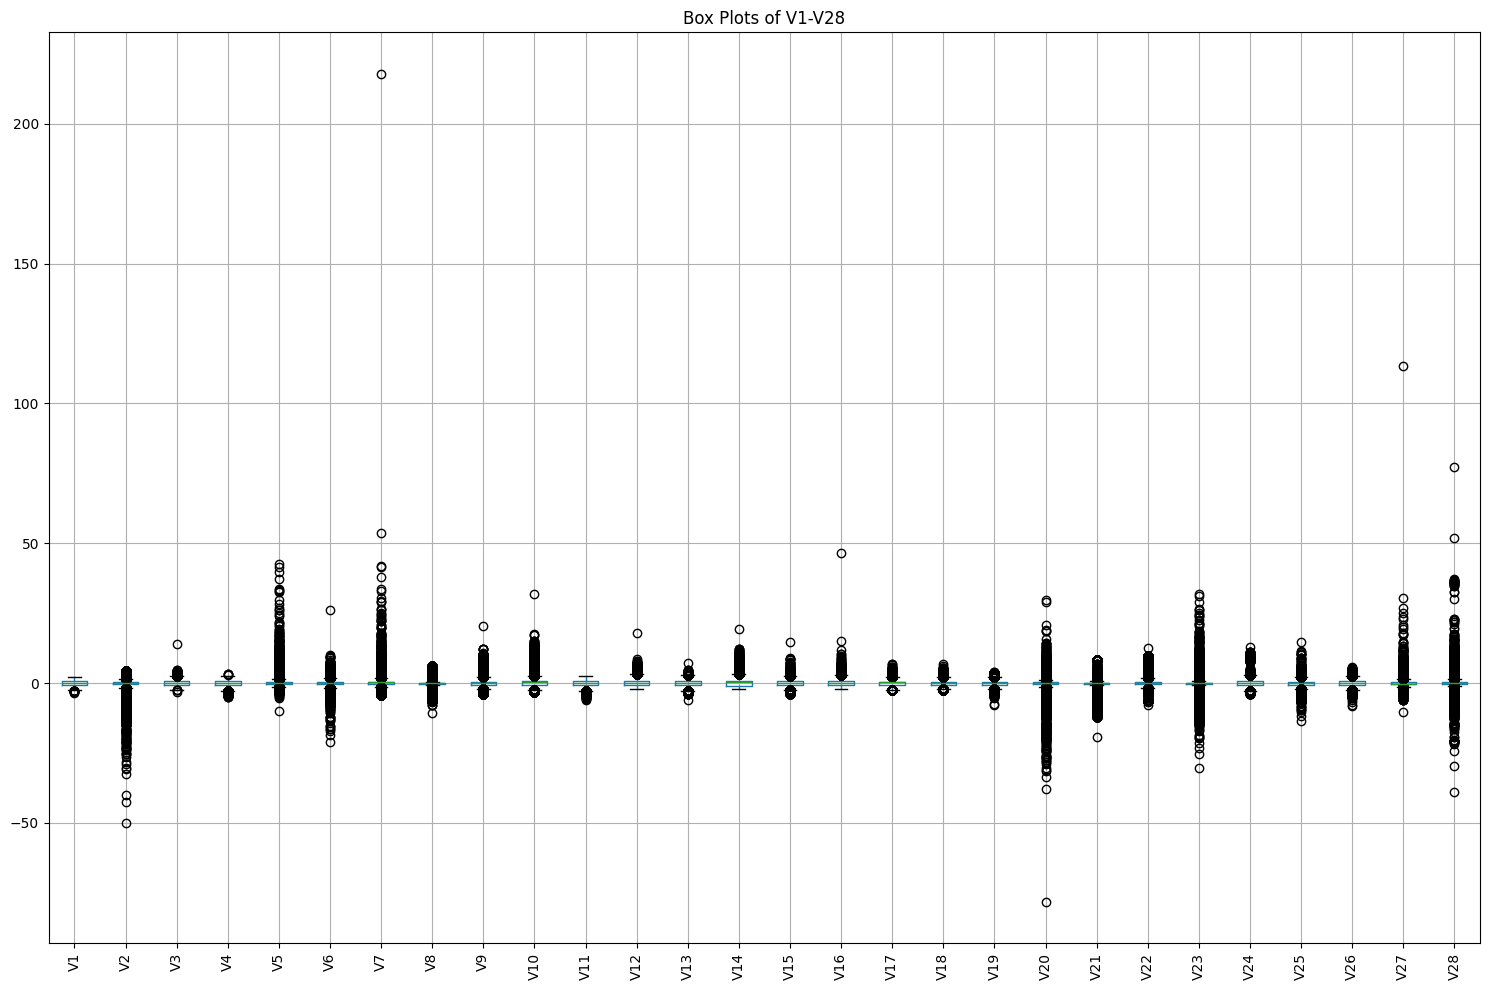

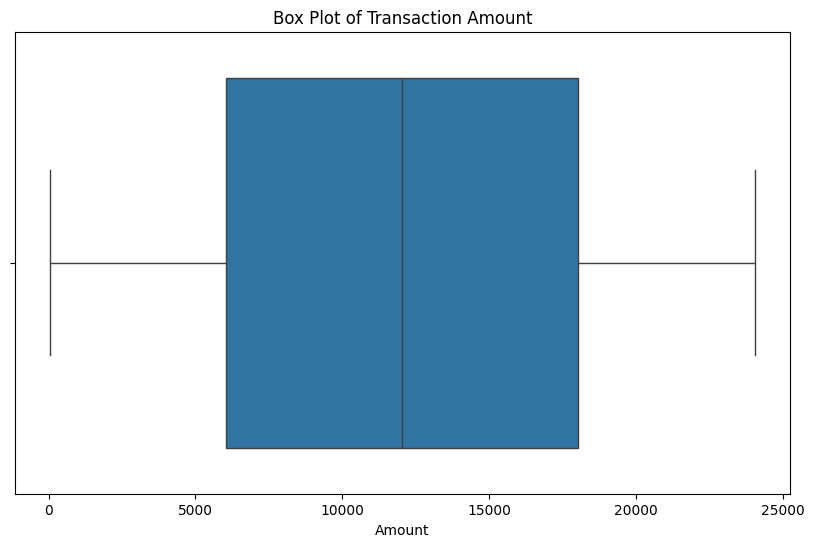

In [29]:
# visualizing the outliers in the data
# Box plots for V1-V28
plt.figure(figsize=(15, 10))
df_pandas.iloc[:, 1:29].boxplot()
plt.title('Box Plots of V1-V28')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Box plot for Amount
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_pandas['Amount'])
plt.title('Box Plot of Transaction Amount')
plt.show()


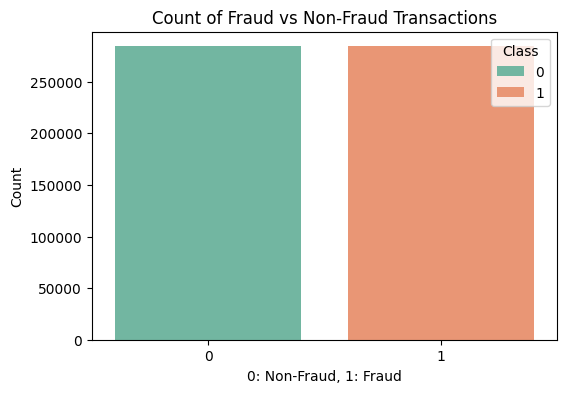

In [30]:
# Plot for each groups' total counts.
plt.figure(figsize=(6, 4))
sns.countplot(data=df_pandas, x='Class', palette='Set2', hue= 'Class')
plt.title('Count of Fraud vs Non-Fraud Transactions')
plt.xlabel('0: Non-Fraud, 1: Fraud')
plt.ylabel('Count')
plt.show()

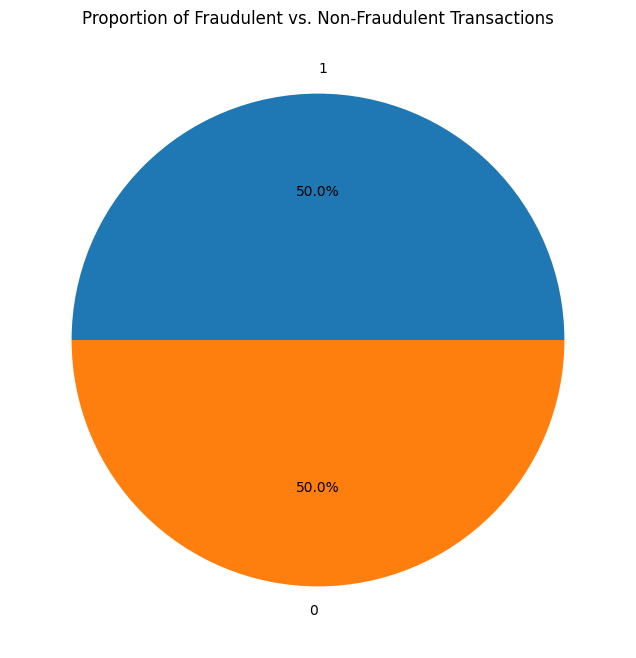

In [31]:
# Pie chart for each groups' in percentage.
class_counts = df.groupBy('class').count().toPandas()

#plotting
plt.figure(figsize=(8, 8))
plt.pie(class_counts['count'], labels=class_counts['class'], autopct='%1.1f%%')
plt.title('Proportion of Fraudulent vs. Non-Fraudulent Transactions')
plt.show()

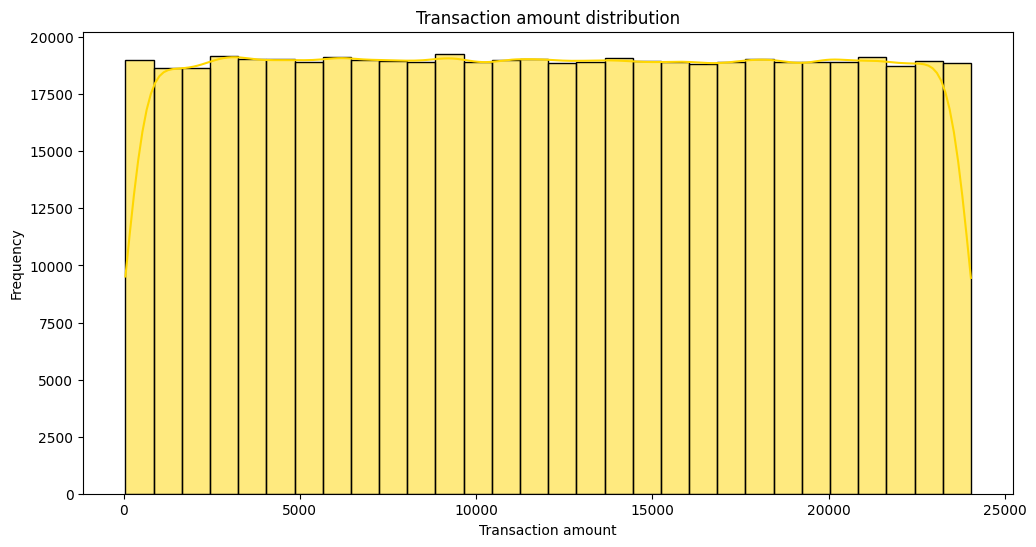

In [32]:
# Amount distribution plot
amount_dist = df.select('amount').toPandas()

#Plotting
plt.figure(figsize=(12, 6))
sns.histplot(amount_dist['amount'], kde=True, bins=30, color='gold')
plt.xlabel('Transaction amount')
plt.ylabel('Frequency')
plt.title('Transaction amount distribution')
plt.show()

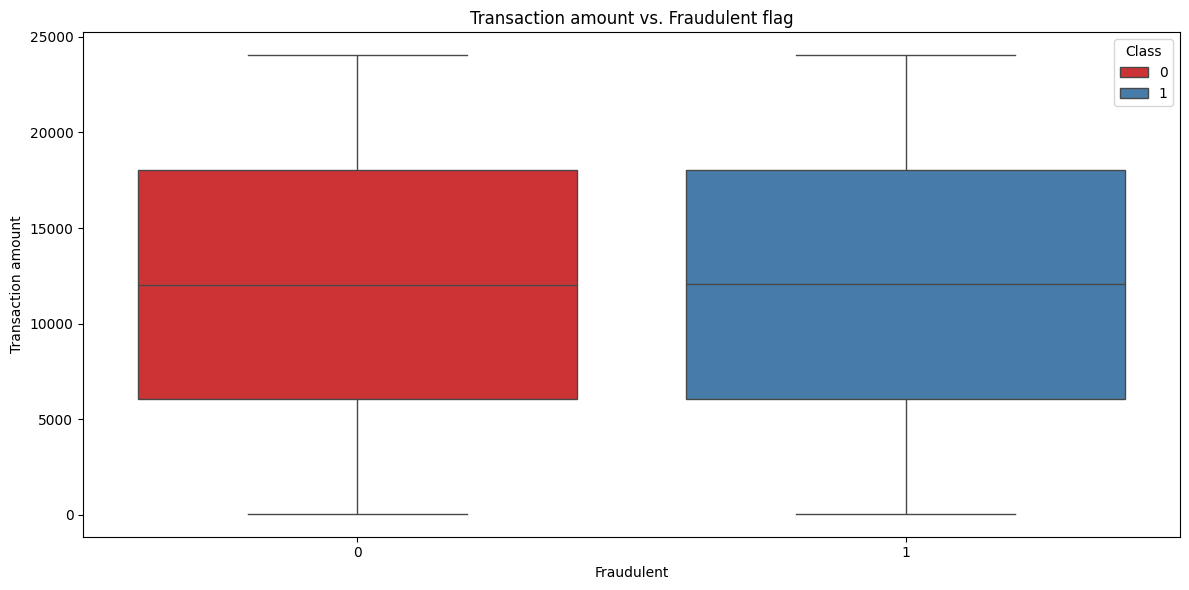

In [35]:
# Box Plot: Transaction Amount by Fraudulent Status
df_pandas = df.toPandas()
# Plotting
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_pandas, x='Class', y='Amount', palette='Set1', hue='Class')
plt.xlabel('Fraudulent')
plt.ylabel('Transaction amount')
plt.title('Transaction amount vs. Fraudulent flag')
plt.tight_layout()
plt.show()

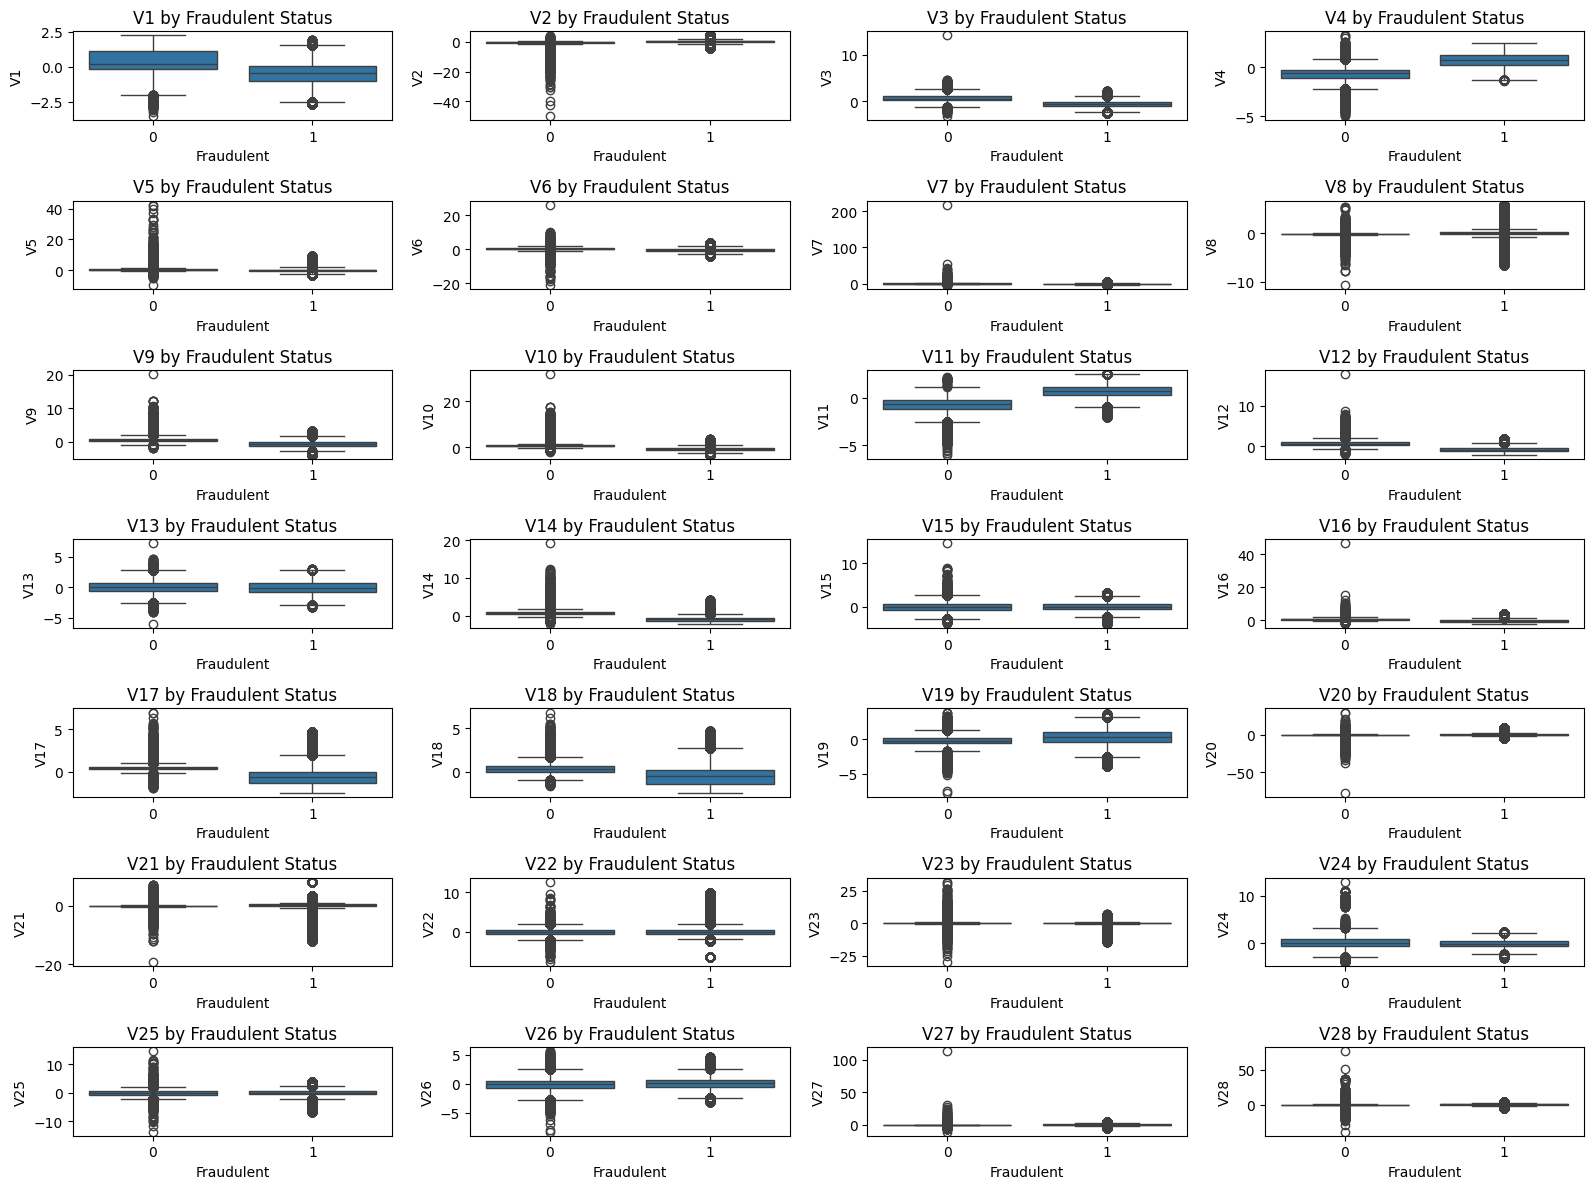

In [41]:
# List of feature columns (v1 to v28)

df_pandas = df.toPandas()

features = [f'V{i}' for i in range(1, 29)]

# Box plot for each features.
plt.figure(figsize=(16, 12))
for i, feature in enumerate(features):
    plt.subplot(7, 4, i+1)
    sns.boxplot(data=df_pandas, x='Class', y=feature)
    plt.xlabel('Fraudulent')
    plt.ylabel(feature)
    plt.title(f'{feature} by Fraudulent Status')

plt.tight_layout()
plt.show()

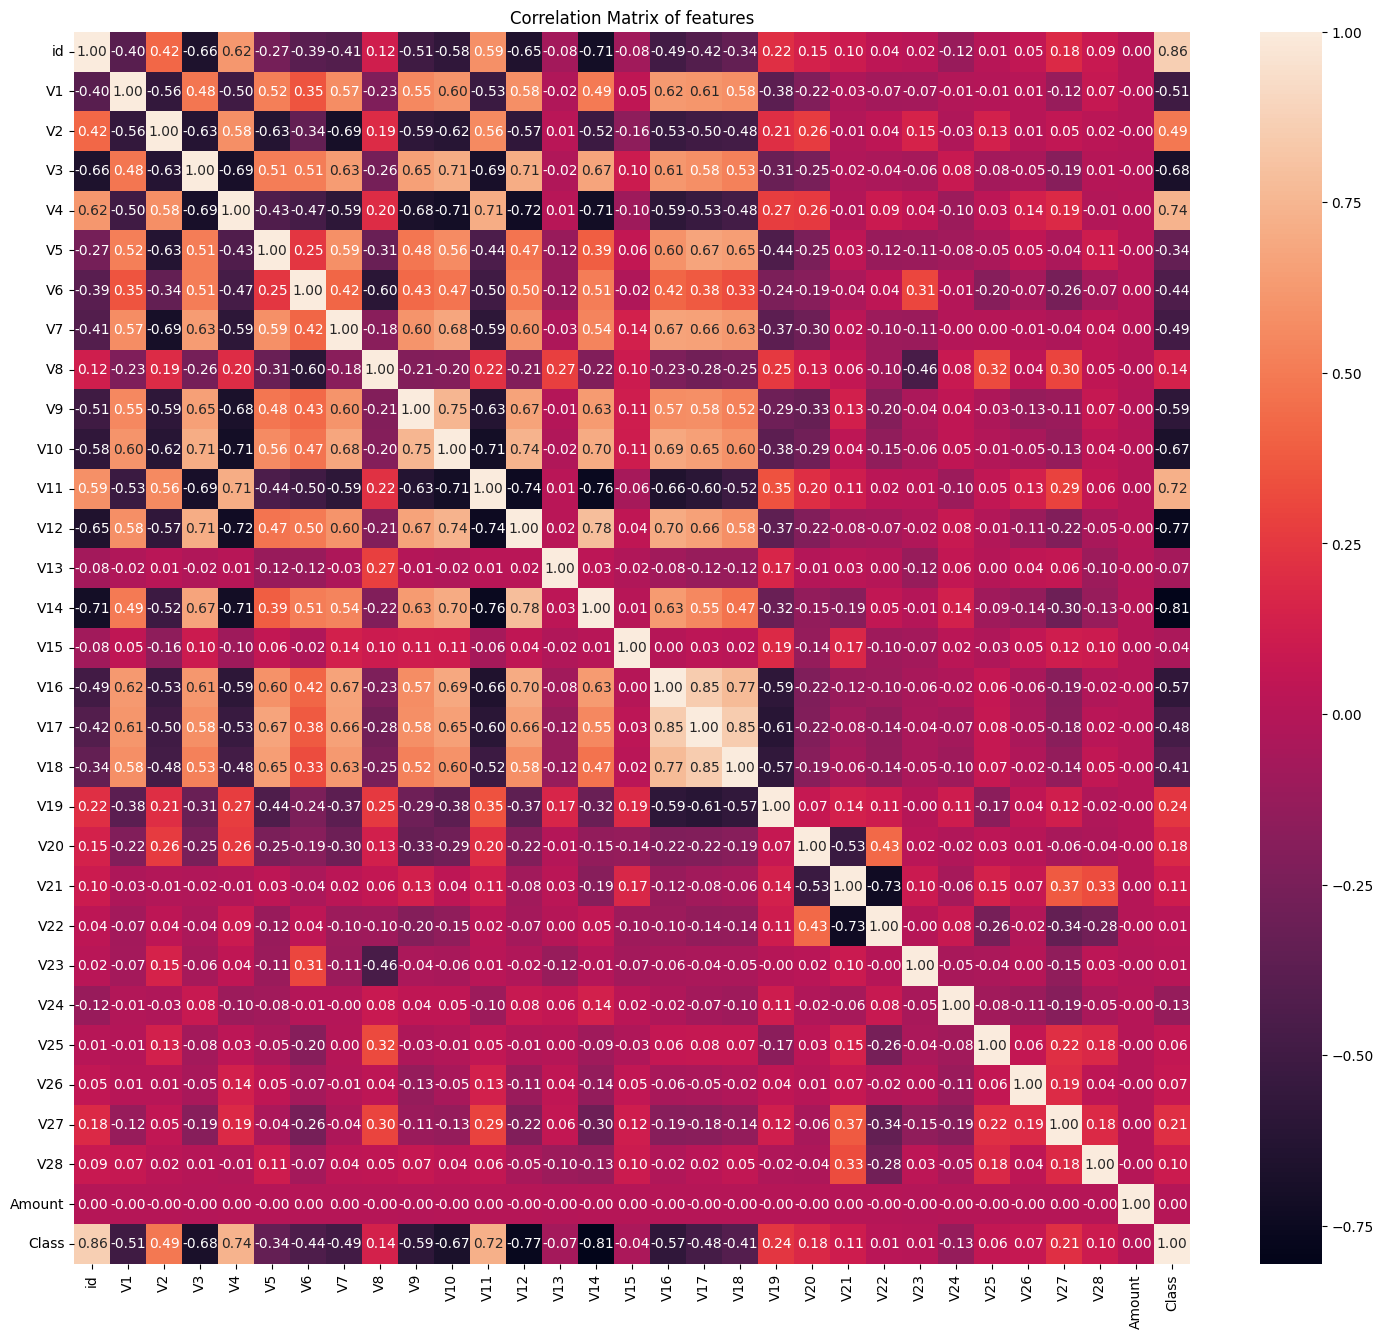

In [82]:
# Compute correlation matrix.
corr_matrix = df_pandas.corr()

# Plotting correlation.
plt.figure(figsize=(18, 16))
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.title("Correlation Matrix of features")
plt.show()

## Machine Learning

In [50]:
spark_df = spark.table("creditcarddata")

# Assemble features(v's) into a single vector column
features = [f"V{i}" for i in range(1, 29)] + ["Amount"]
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(spark_df)

# Select features(v's) and label
data = data.select(col("features"), col("class").alias("label"))

# Split the data into 80% and 20% for training and testing sets respectively
# seed option enables the same random numbers when we train the model that improves the consistency of the result.
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

## Logistics Regression

In [51]:
# Building and training the Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)

# Predictions
lr_predictions = lr_model.transform(test_data)

# Evaluation of model
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol='rawPrediction', metricName='areaUnderROC')
lr_auc = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression AUC: {lr_auc:.4f}")

Logistic Regression AUC: 0.9936


In [52]:
# Calculate the confusion matrix components: TP, FP, TN, FN
TP = lr_predictions.filter((col('prediction') == 1) & (col('label') == 1)).count()
FP = lr_predictions.filter((col('prediction') == 1) & (col('label') == 0)).count()
TN = lr_predictions.filter((col('prediction') == 0) & (col('label') == 0)).count()
FN = lr_predictions.filter((col('prediction') == 0) & (col('label') == 1)).count()

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

# Create a confusion matrix
confusion_matrix1 = [[TN, FP], [FN, TP]]

True Positives (TP): 54109
False Positives (FP): 1212
True Negatives (TN): 55229
False Negatives (FN): 2775


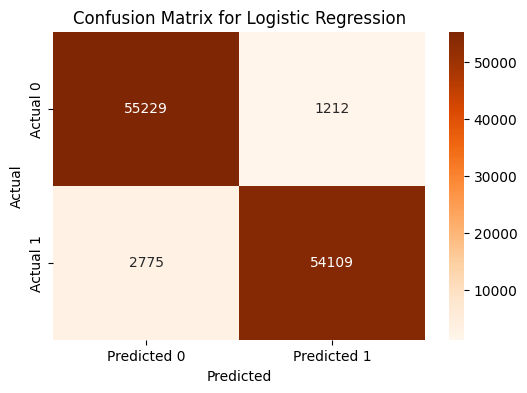

In [53]:
# Convert the confusion matrix to a pandas DataFrame
confusion_df = pd.DataFrame(confusion_matrix1, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Oranges")
plt.title('Confusion Matrix for Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Random Forest

In [54]:
# Create and train the Random Forest model
rf = RandomForestClassifier(featuresCol="features", labelCol="label")
rf_model = rf.fit(train_data)

# Predictions
rf_predictions = rf_model.transform(test_data)

# Model evalution
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Random Forest AUC: {rf_auc:.4f}")

Random Forest AUC: 0.9880


In [55]:
# Calculate the confusion matrix components: TP, FP, TN, FN
TP = rf_predictions.filter((col('prediction') == 1) & (col('label') == 1)).count()
FP = rf_predictions.filter((col('prediction') == 1) & (col('label') == 0)).count()
TN = rf_predictions.filter((col('prediction') == 0) & (col('label') == 0)).count()
FN = rf_predictions.filter((col('prediction') == 0) & (col('label') == 1)).count()

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

# Create a confusion matrix
confusion_matrix2 = [[TN, FP], [FN, TP]]

True Positives (TP): 51719
False Positives (FP): 188
True Negatives (TN): 56253
False Negatives (FN): 5165


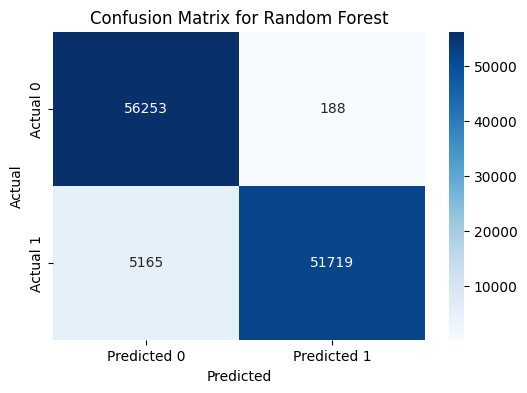

In [56]:
# Convert the confusion matrix to a pandas DataFrame
confusion_df = pd.DataFrame(confusion_matrix2, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix for Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Gradient-Boosted Trees model

In [57]:
# Create and train the Gradient-Boosted Trees model
gbt = GBTClassifier(featuresCol="features", labelCol="label")
gbt_model = gbt.fit(train_data)

# Predictions
gbt_predictions = gbt_model.transform(test_data)

# Model evalution
gbt_auc = evaluator.evaluate(gbt_predictions)
print(f"GBT AUC: {gbt_auc:.4f}")

GBT AUC: 0.9972


In [58]:
# Calculate the confusion matrix components: TP, FP, TN, FN
TP = gbt_predictions.filter((col('prediction') == 1) & (col('label') == 1)).count()
FP = gbt_predictions.filter((col('prediction') == 1) & (col('label') == 0)).count()
TN = gbt_predictions.filter((col('prediction') == 0) & (col('label') == 0)).count()
FN = gbt_predictions.filter((col('prediction') == 0) & (col('label') == 1)).count()

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

# Create a confusion matrix
confusion_matrix3 = [[TN, FP], [FN, TP]]

True Positives (TP): 54389
False Positives (FP): 776
True Negatives (TN): 55665
False Negatives (FN): 2495


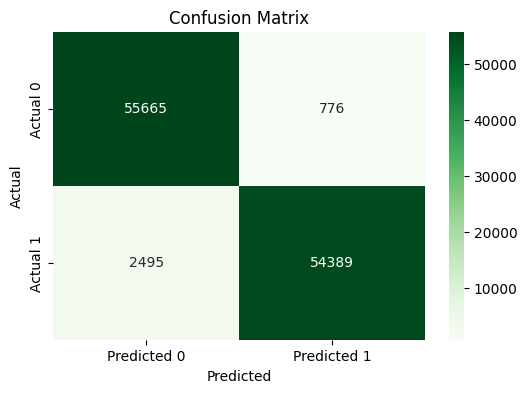

In [59]:
# Convert the confusion matrix to a pandas DataFrame
confusion_df = pd.DataFrame(confusion_matrix3, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Greens")
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [60]:
# Create and train the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)

# Predictions
lr_predictions = lr_model.transform(test_data)

# Model evaluation
lr_summary = lr_model.evaluate(test_data)
print(f"Linear Regression RMSE: {lr_summary.rootMeanSquaredError:.4f}")
print(f"Linear Regression R2: {lr_summary.r2:.4f}")

Linear Regression RMSE: 0.2433
Linear Regression R2: 0.7632


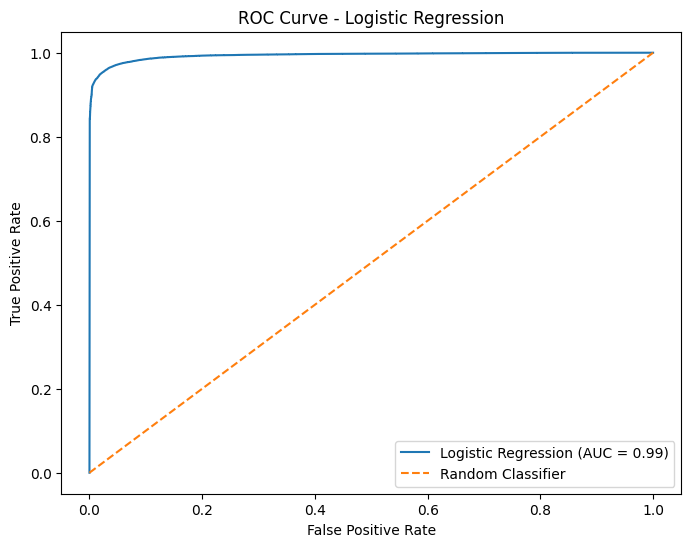

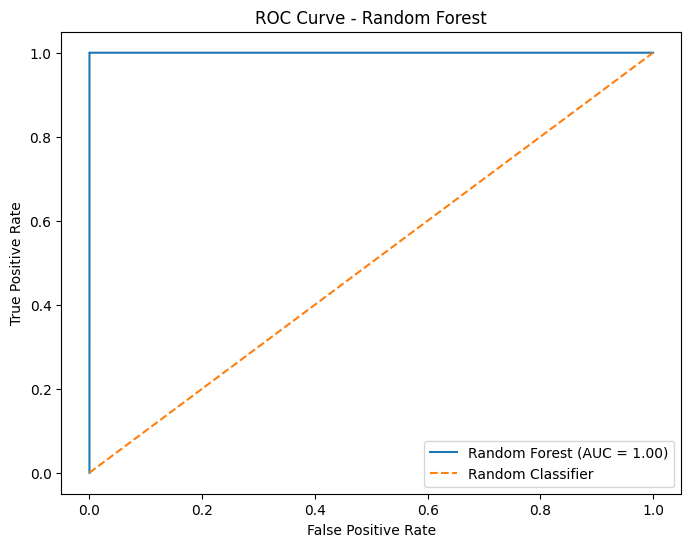

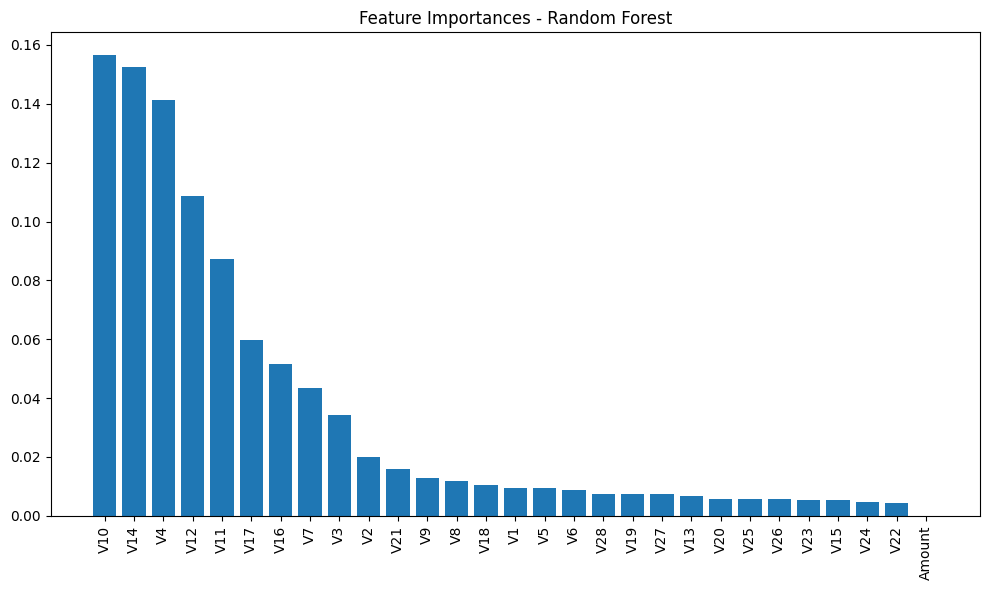

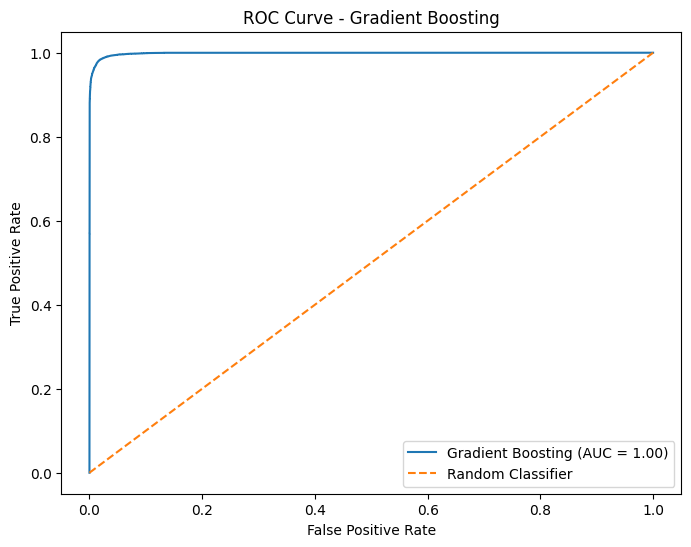

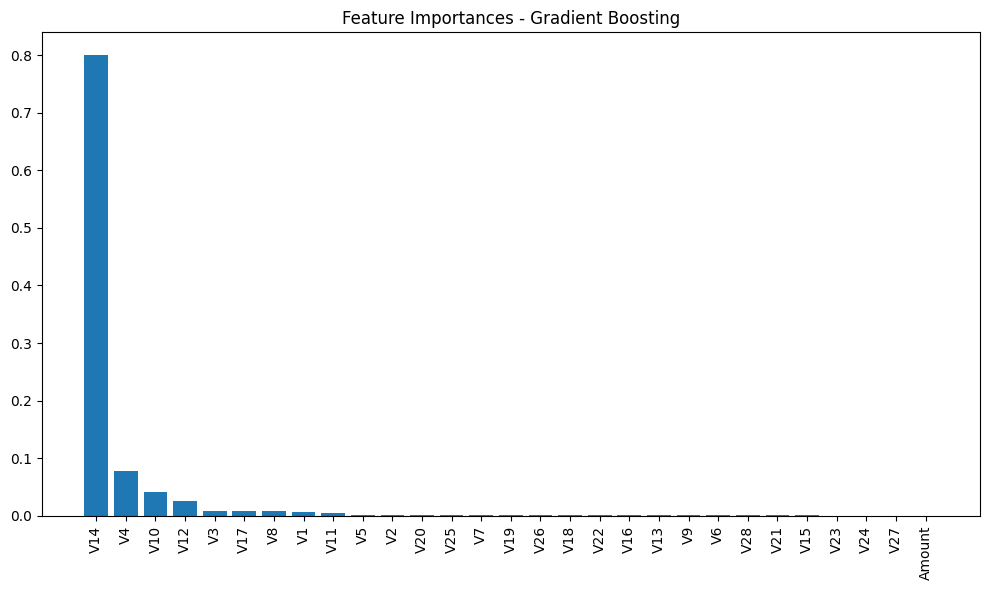

                 Model  Accuracy  Precision    Recall  F1 Score   AUC-ROC
1        Random Forest  0.999833   0.999666  1.000000  0.999833  0.999990
2    Gradient Boosting  0.979292   0.988581  0.969787  0.979094  0.998644
0  Logistic Regression  0.964977   0.977170  0.952201  0.964524  0.993500


In [41]:
df = df_pandas
X = df.drop(['id', 'Class'], axis=1)
y = df['Class']

def train_evaluate_models(X, y, test_size=0.2, random_state=42):
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # Scaling the features using standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Defining Various models
    models = {
        'Logistic Regression': LogisticRegression(random_state=random_state),
        'Random Forest': RandomForestClassifier(random_state=random_state, n_jobs=-1),
        'Gradient Boosting': GradientBoostingClassifier(random_state=random_state)
    }
    
    results = []
    
    for name, model in models.items():
        
        # Model training
        model.fit(X_train_scaled, y_train)
        
        # Making predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Calculating score metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_pred_proba)
        
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC-ROC': auc_roc
        })
        
        # Plot ROC curve
        from sklearn.metrics import roc_curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_roc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.show()

        # Feature importance (for tree-based models)
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            feature_names = X.columns
            
            plt.figure(figsize=(10, 6))
            plt.title(f"Feature Importances - {name}")
            plt.bar(range(X.shape[1]), importances[indices])
            plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
            plt.tight_layout()
            plt.show()
    return pd.DataFrame(results)

results_df = train_evaluate_models(X, y)

# Sorting results by AUC-ROC score
results_df = results_df.sort_values('AUC-ROC', ascending=False)

#Results
print(results_df)